In [1]:
import sys, re, string as strg, numpy as np, pandas as pd
from collections import Counter
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import f1_score
%matplotlib inline

#### Functions

In [2]:
def tokenize(string):
    a = re.sub('(@\w+)|http[s]*[^\s]*', '', string).lower()
    translator = a.maketrans('', '', strg.punctuation)
    a = a.translate(translator)
    stopwords = ['the', 'and', 'you', 'that', 'was', 'for', 'are', 'with', 'they', 'this', 'have', 'from', 'one', 'had', 'word', 'but', 'not', 'what', 'all', 'were']
    return [x for x in re.findall('[a-zA-z]{3,}', a) if x not in stopwords]

In [3]:
def sigmoid(number):
    return 1/(1+np.exp(-number))

In [4]:
def log_likelihood(featmatrix, bvector, classvector):
    # Referenced: https://beckernick.github.io/logistic-regression-from-scratch/ >> Full citation in writeup
    score = featmatrix.dot(bvector)
    likelihood = np.sum(classvector*score - np.log(1+np.exp(score)))
    return likelihood

In [5]:
def compute_gradient(featmatrix, bvector, classvector):
    predictionvector = sigmoid(featmatrix.dot(bvector))
    cost = classvector - predictionvector
    gradient = featmatrix.T.dot(cost).T
    return gradient

In [6]:
def build_spmatrix(vocabdict, tokenlist):
    # Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html >> Full citation in writeup
    indptr = [0]
    indices = []
    data = []
    doccount = 0
    for d in tokenlist:
        for term in d:
            if term in vocabdict.keys():
                index = vocabulary[term]
                indices.append(index)
                data.append(1)
            else:
                continue
        doccount += 1

        indptr.append(len(indices))
    
    featmatrix = csr_matrix((data, indices, indptr), dtype=int, shape=(doccount,len(vocabdict.keys())))
    newcol = csr_matrix(np.ones((featmatrix.shape[0],1)))
    
    return csr_matrix(hstack([featmatrix, newcol]))

In [8]:
def logistic_regression(featmatrix, classvector, learningrate, num_step, intercept=False):
    # Referenced: https://beckernick.github.io/logistic-regression-from-scratch/ >> Full citation in writeup
    weights = np.zeros(featmatrix.shape[1])
    
    for step in np.arange(num_step):
        if featmatrix.shape[0]-step <= 0:
            i = step % featmatrix.shape[0]
        else:
            i = step
        gradient = compute_gradient(featmatrix[i], weights, classvector[i])
        weights += gradient*learningrate
    
        if step % 10000 == 0:
            print(log_likelihood(featmatrix, weights, classvector))
    
    if intercept == False:
        weights[-1] = 0
    return weights

In [9]:
def classify(countedtokens, weights):
    if sigmoid(countedtokens.dot(weights)) > 0.5:
        return 1
    else:
        return 0

#### Training

In [10]:
traindata = pd.read_table('train.tsv', delimiter='\t', quoting=3, index_col=0)
dat = [x for x in map(tokenize, traindata.text)]

vocabulary = {}
for d in dat:
    for term in d:
        vocabulary.setdefault(term, len(vocabulary))

In [11]:
featmatrix = build_spmatrix(vocabulary, dat)

In [12]:
finalweight = logistic_regression(featmatrix, traindata['class'].values, 0.00005,  300000, False)

(35828, 32929)
-24834.039126
-24528.2757446
-24244.4766403
-23960.8207461
-23691.4176709
-23432.0702365
-23183.3711588
-22940.7258047
-22707.3775515
-22483.1314836
-22264.8559056
-22054.7368339
-21849.2051816
-21653.0931121
-21459.6350747
-21274.5777407
-21094.5366743
-20919.0084224
-20749.4873189
-20583.3453908
-20424.5740529
-20266.6190738
-20115.7710523
-19967.377752
-19823.9786556
-19683.7829867
-19545.9228565
-19414.0840754
-19283.7168899
-19156.9710732


In [13]:
finalweight

array([-0.01021285, -0.00030345, -0.00618091, ..., -0.00017612,
        0.0001954 ,  0.        ])

#### Dev data

In [14]:
devdata = pd.read_table('dev.tsv', delimiter='\t', quoting=3, index_col=0)
devmatrix = build_spmatrix(vocabulary, [x for x in map(tokenize, devdata.text)])

In [15]:
devmatrix

<4478x32929 sparse matrix of type '<class 'numpy.float64'>'
	with 35749 stored elements in Compressed Sparse Row format>

In [16]:
result = pd.DataFrame({'class':[classify(devmatrix[x], finalweight) for x in range(devmatrix.shape[0])]}, index=devdata.index)


In [17]:
f1_score(devdata['class'], result['class'])

0.80835676978706306

#### Implementation on test data

In [18]:
testdata = pd.read_table('test.unlabeled.tsv', delimiter='\t', quoting=3, index_col=0)
testmatrix = build_spmatrix(vocabulary, [x for x in map(tokenize, testdata.text)])

In [19]:
testmatrix

<4478x32929 sparse matrix of type '<class 'numpy.float64'>'
	with 35905 stored elements in Compressed Sparse Row format>

In [20]:
bestweight = logistic_regression(featmatrix, traindata['class'].values, 0.0275,  500000, True)

(35828, 32929)
-24814.1634709
-8603.53874767
-7058.97211958
-6338.79588175
-5780.61722686
-5436.17507278
-5181.98037926
-4914.79834265
-4731.79758338
-4580.5280228
-4438.13587883
-4315.0028361
-4210.67801894
-4115.99207002
-4018.06105888
-3967.77215714
-3864.97776167
-3796.32864289
-3725.32445401
-3673.6284318
-3612.10337395
-3603.2657749
-3505.18618647
-3458.3334525
-3411.57823743
-3366.81878537
-3336.37470334
-3298.60761461
-3248.71717362
-3210.84070736
-3205.36441104
-3143.50151126
-3114.61378204
-3079.30011145
-3050.69152918
-3021.38789876
-3005.12160028
-2967.0144889
-2938.6449604
-2929.83222285
-2891.79708591
-2870.85800797
-2838.14445009
-2868.46498356
-2794.09607738
-2794.49948077
-2751.98883942
-2728.78877743
-2712.71567113
-2700.66575922


In [21]:
testproduct = pd.DataFrame({'class':[classify(testmatrix[x], bestweight) for x in range(testmatrix.shape[0])]}, index=testdata.index)

In [22]:
testproduct.to_csv('logisticsubmit.csv')

#### For paper

In [25]:
def logistic_graph(featmatrix, classvector, learningratelst, num_step, intercept=False):
    # Referenced: https://beckernick.github.io/logistic-regression-from-scratch/
 
    logtenk = {}
    
    #use hstack later for intercept
    weights = np.zeros(featmatrix.shape[1])
    
    for x in learningratelst:
        loglike = []
        for step in np.arange(num_step):
            if featmatrix.shape[0]-step <= 0:
                i = step % featmatrix.shape[0]
            else:
                i = step
            gradient = compute_gradient(featmatrix[i], weights, classvector[i])
            weights += gradient*x

            if step % 10000 == 0:
                loglike.append(log_likelihood(featmatrix, weights, classvector))

        if intercept == False:
            weights[-1] = 0
        
        logtenk[x] = loglike
    return logtenk

In [27]:
grph = logistic_graph(featmatrix, traindata['class'].values, [5e-8, 5e-5, 2],  300000, False)

In [60]:
grphdf = pd.DataFrame(grph, index=(np.arange(30)*10000))
grphdf

,5e-08,5e-05,2.0
0,-24834.077147,-24825.713939,-20548.616824
10000,-24833.765340,-24520.238449,-10484.866403
20000,-24833.465074,-24236.696752,-8806.370351
30000,-24833.153204,-23953.307832,-7197.516204
40000,-24832.845291,-23684.155062,-6277.071587
50000,-24832.538840,-23425.056893,-5874.382173
60000,-24832.233591,-23176.589239,-4417.940880
70000,-24831.924904,-22934.168630,-6394.720789
80000,-24831.617840,-22701.038413,-3960.776191
90000,-24831.313627,-22476.999333,-4336.457371


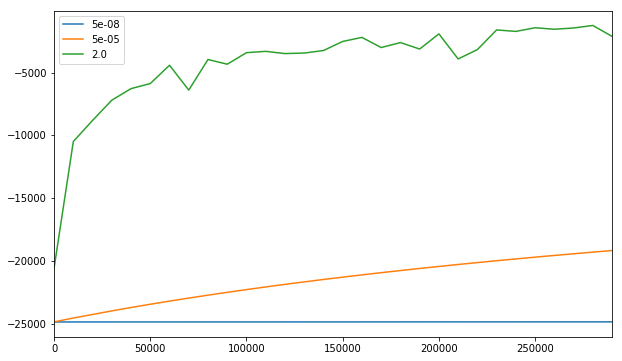

In [61]:
grphdf.plot(x=grphdf.index, figsize=(10, 6)).get_figure().savefig('Learningrates.png')

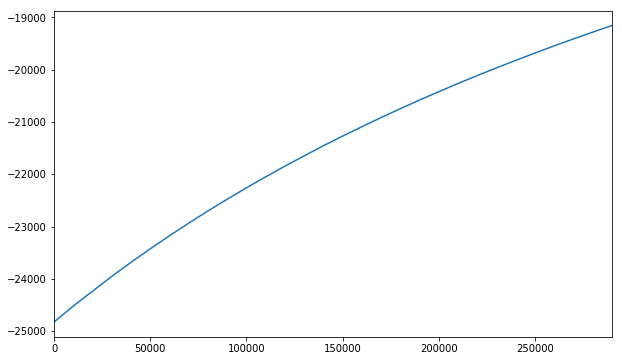

In [62]:
grphdf[5e-05].plot(figsize=(10, 6)).get_figure().savefig('low learn.png')